In [1]:
from lz78 import DirichletLZ78Source, DiracDirichletLZ78Source, mu_k
from sys import stdout
import numpy as np
from scipy.special import gamma as GammaFunc
import scipy.special as sp
from typing import Union

import matplotlib.pyplot as plt
from colour import Color

SQRT_PI = np.sqrt(np.pi)
LOG2 = np.log(2)
EULER_MASCH = 0.57721566490153286060651209008240243104215933593992

In [2]:
def harmonic_number(n):
    return sp.digamma(n + 1) + EULER_MASCH

def binary_entropy(p):
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1-p) * np.log2(1-p)

In [3]:
def compute_lz78_dirichlet_entropy_rate(a):
    if a == 0:
        return 0
    return -2 * GammaFunc(2*a) * (
        4**(-a) * SQRT_PI * GammaFunc(a) * (
            harmonic_number(a) - harmonic_number(2*a)
        )
    ) / (
        GammaFunc(a + 1/2) * GammaFunc(a)**2 * LOG2
    )
compute_lz78_dirichlet_entropy_rate = np.vectorize(
    compute_lz78_dirichlet_entropy_rate,
    otypes=[np.float64]
)

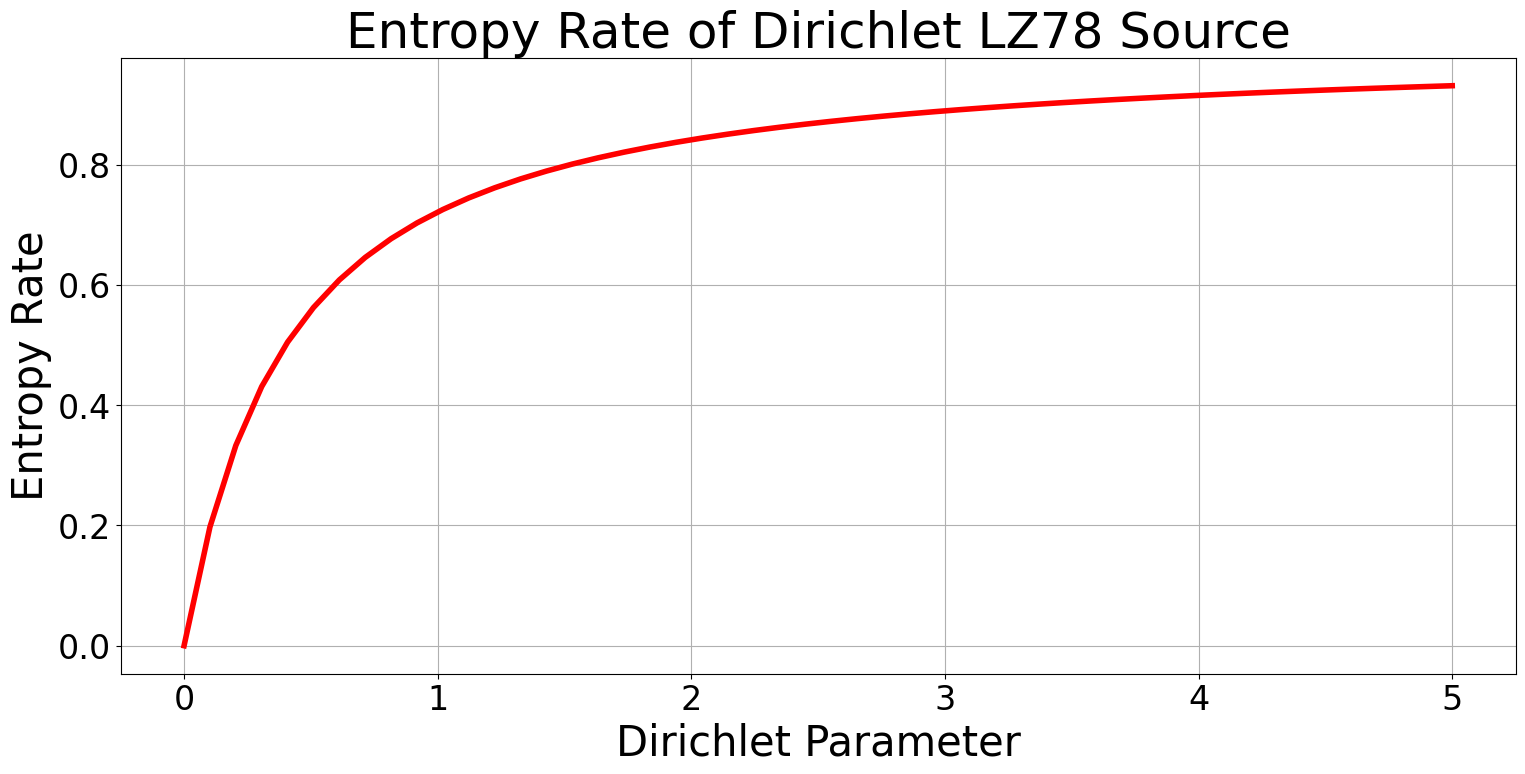

In [4]:
gammas = np.linspace(0, 5)
vals = compute_lz78_dirichlet_entropy_rate(gammas)

plt.figure(figsize=(18,8))

plt.plot(
    gammas, vals, "-", linewidth=4, markersize=4,
    color="red",
)
    
plt.title(f"Entropy Rate of Dirichlet LZ78 Source", fontdict={"size": 36})
plt.xlabel("Dirichlet Parameter", fontdict={"size": 30})
plt.ylabel("Entropy Rate", fontdict={"size": 30})
plt.tick_params(labelsize=24)
plt.grid(True)

In [5]:
def compute_lz78_dirac_dirichlet_entropy_rate(gamma, delta, dirac_loc):
    dirac_entropy = binary_entropy(dirac_loc)
    dirichlet_entropy = compute_lz78_dirichlet_entropy_rate(gamma)
    return (1-delta) * dirac_entropy + delta * dirichlet_entropy

In [6]:
def source_experiment(
    ns: list[int], gamma:float=None, source:Union[DirichletLZ78Source,DiracDirichletLZ78Source]=None, seed=42
) -> tuple[list[int], list[float], DirichletLZ78Source]:
    if source is None:
        assert gamma is not None, "source and gamma cannot both be None"
        source = DirichletLZ78Source(2, gamma=gamma, seed=seed)
    
    prev_n = 0
    result = []
    seq = []
    for n in ns:
        seq.extend(source.generate_symbols(n - prev_n))
        prev_n = n
        result.append(source.get_scaled_log_loss())

    return seq, result, source

In [7]:
def compute_mu_ks(seq: list[int], ns: list[int], k: int, a=2,) -> list[float]:
    losses = []
    for n in ns:
        losses.append(mu_k(seq[:n], a, k))
    return losses

## Experiments: Dirichlet Source

In [67]:
GAMMA = 1.1
END = 8
x = [int(round(x)) for x in np.logspace(1, 8, 20)]
N = 5

In [68]:
# import pickle
# with open(f"dirichlet_gamma_{GAMMA}_source.npy", "rb") as f:
#     loaded = pickle.load(f)
# loss_trials = loaded["loss_trials"]
# x = loaded["times"]
# mu_0 = loaded["mu_0"]
# mu_5 = loaded["mu_5"]
# mu_10 = loaded["mu_10"]

In [69]:
stdout.flush()
loss_trials = []
for i in range(N):
    _, losses, _ = source_experiment(x, GAMMA, DirichletLZ78Source(3, GAMMA, seed=i), seed=i)
    loss_trials.append(losses)

In [72]:
entropy_rate = compute_lz78_dirichlet_entropy_rate(GAMMA)
entropy_rate = 1.22992
mu = binary_entropy(1/2) * np.log2(3)

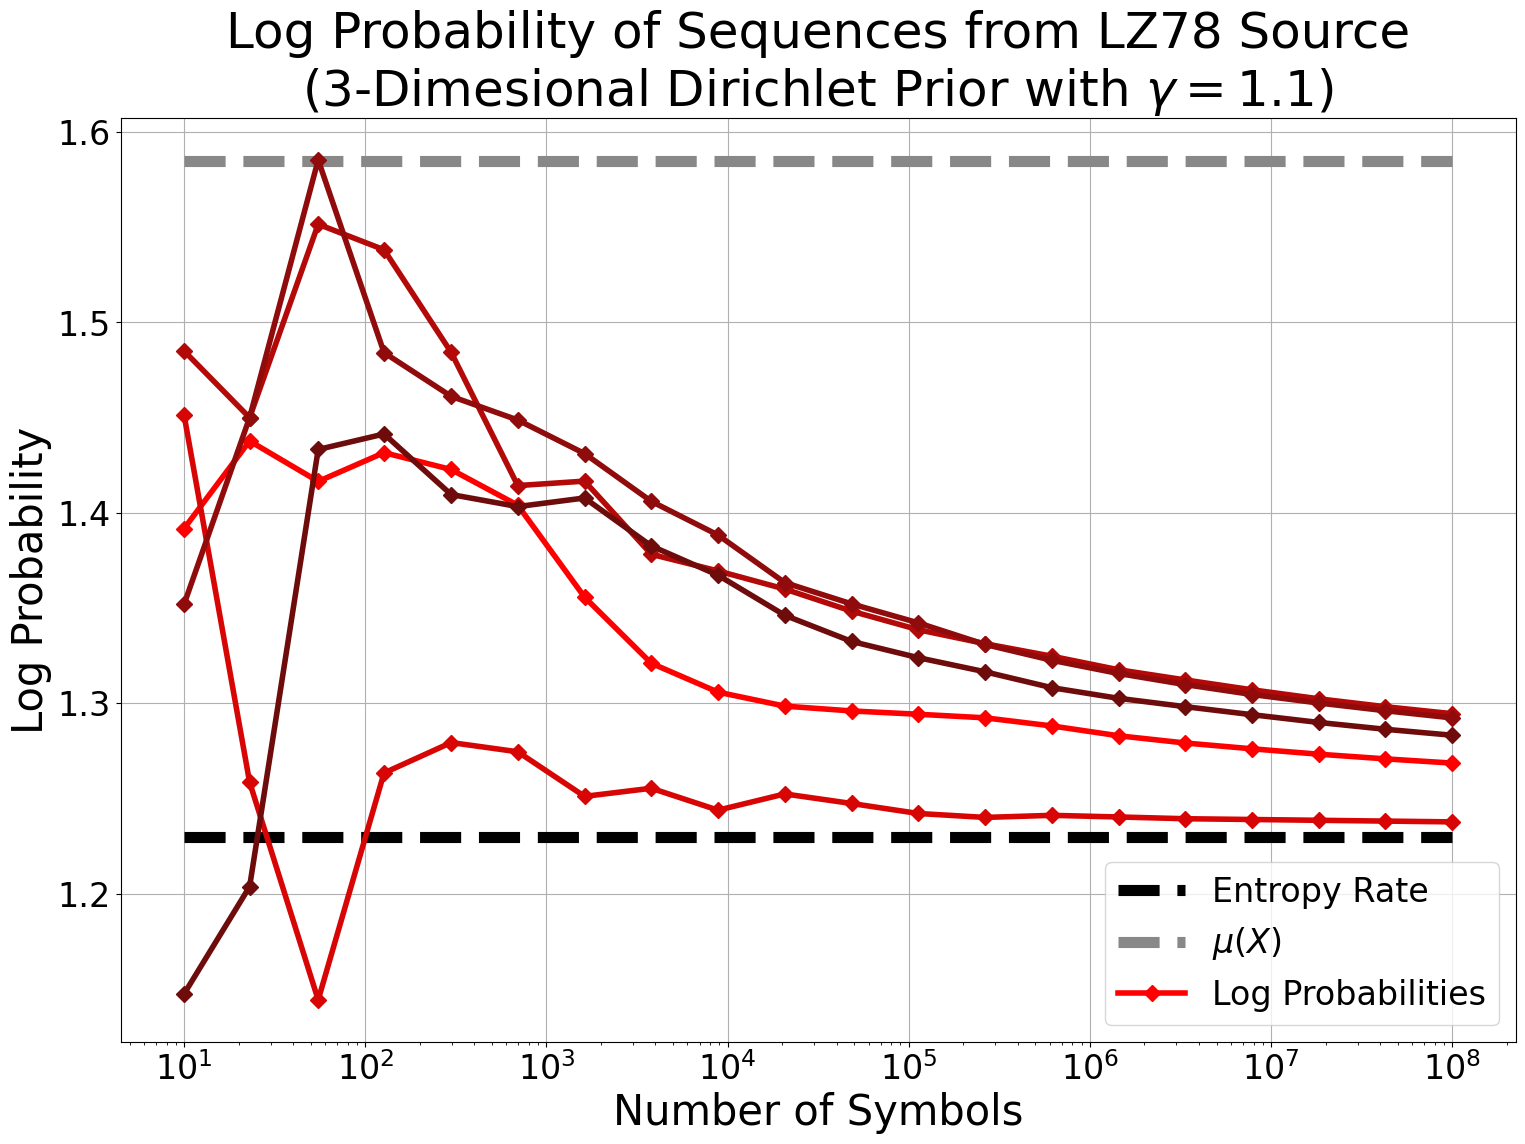

In [74]:
colors = list(Color("#ff0000").range_to(Color("#6e0b0b"),N))

plt.figure(figsize=(18,12))
plt.plot(
    x, np.ones(len(x)) * entropy_rate,
    'k--', linewidth=8, label="Entropy Rate"
)
plt.plot(
    x, np.ones(len(x)) * mu, '--', linewidth=8,
    color="#888888", label="$\mu(X)$"
)

plt.plot(
    x, loss_trials[0], "-D", linewidth=4, markersize=8,
    color="red", label="Log Probabilities"
)
for i in range(1, N):
    plt.plot(
        x, loss_trials[i], "-D", linewidth=4, markersize=8,
        color=colors[i].get_hex()
    )
    
plt.legend(fontsize=24)
plt.xscale("log")
plt.title(f"Log Probability of Sequences from LZ78 Source\n(3-Dimesional Dirichlet Prior with $\gamma=${GAMMA})", fontdict={"size": 36})
plt.xlabel("Number of Symbols", fontdict={"size": 30})
plt.ylabel("Log Probability", fontdict={"size": 30})
plt.tick_params(labelsize=24)
plt.grid(True)

In [86]:
stdout.flush()
seq, log_probs, _ = source_experiment(x, GAMMA, DirichletLZ78Source(3, GAMMA, seed=i), seed=42)
mu_0 = compute_mu_ks(seq, x, k=0, a=3)
mu_5 = compute_mu_ks(seq, x, k=5, a=3)
mu_10 = compute_mu_ks(seq, x, k=10, a=3)
# mu_31 = compute_mu_ks(seq, x, k=31)

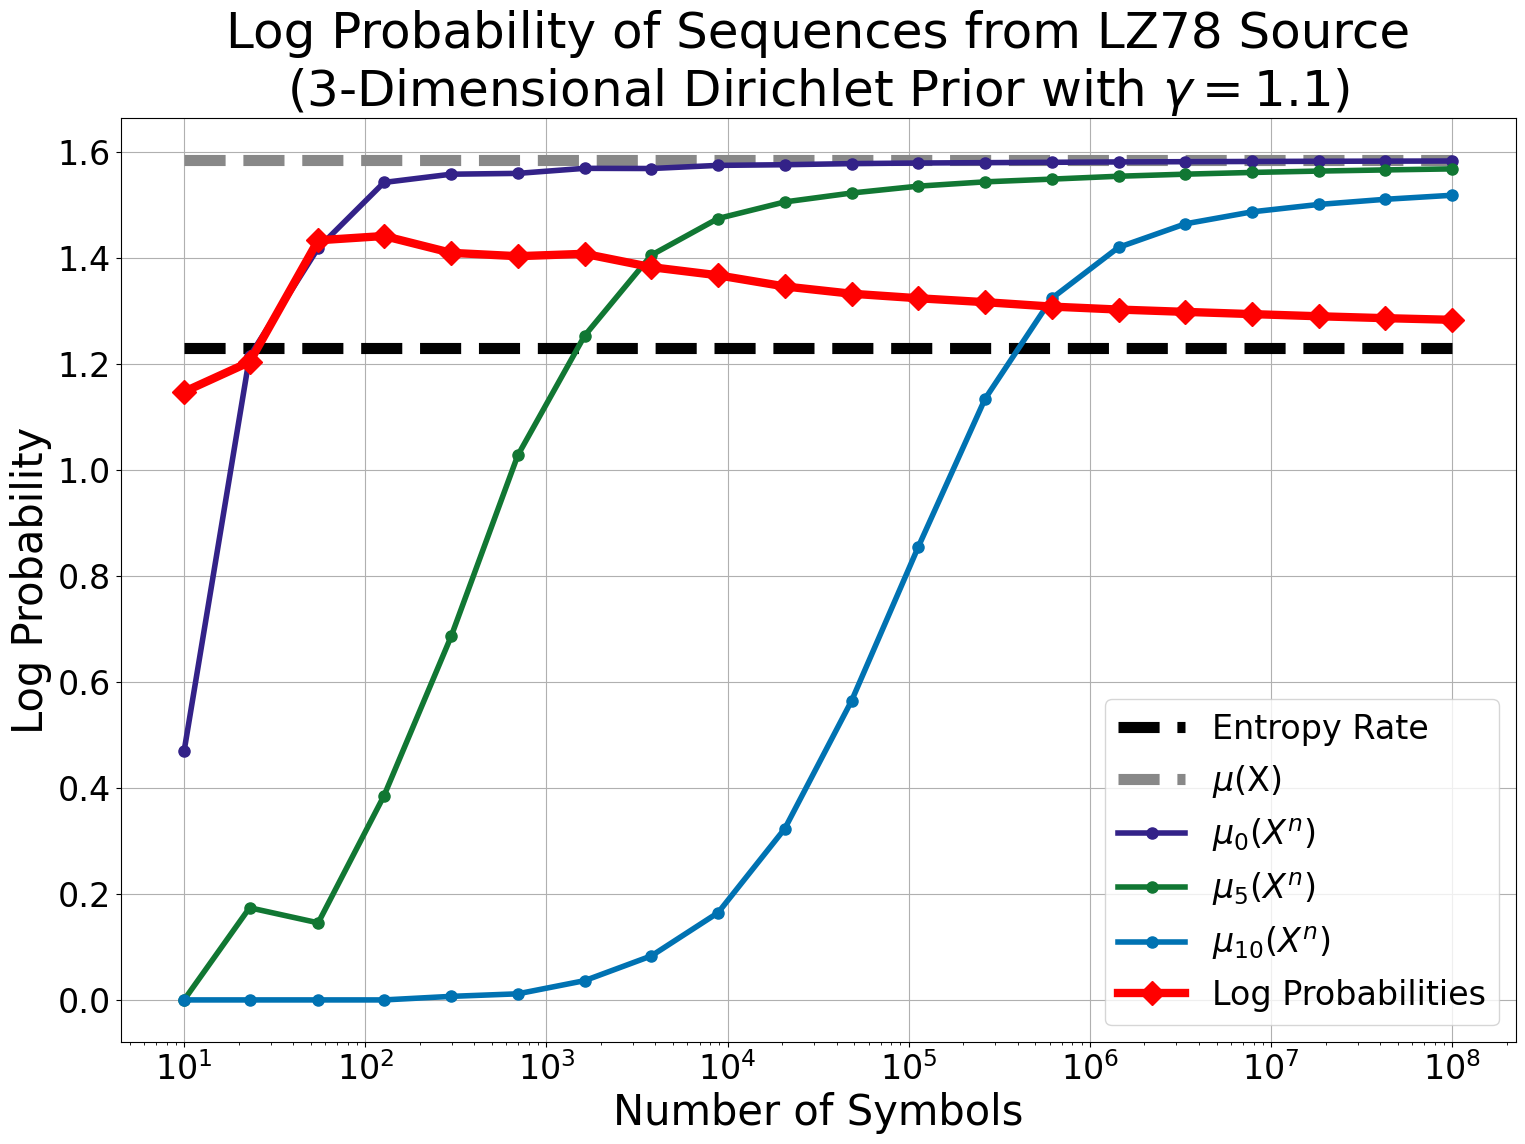

In [82]:
plt.figure(figsize=(18,12))
plt.plot(
    x, np.ones(len(x)) * entropy_rate,
    'k--', linewidth=8, label="Entropy Rate"
)
plt.plot(
    x, np.ones(len(x)) * mu, '--', linewidth=8,
    color="#888888", label="$\mu$(X)"
)

plt.plot(
    x, mu_0, "-o", linewidth=4, markersize=8,
    color="#332288", label="$\mu_0(X^n)$"
) 
plt.plot(
    x, mu_5, "-o", linewidth=4, markersize=8,
    color="#117733", label="$\mu_5(X^n)$"
) 
plt.plot(
    x, mu_10, "-o", linewidth=4, markersize=8,
    color="#0072B2", label="$\mu_{10}(X^n)$"
)
# plt.plot(
#     x, mu_31, "-o", linewidth=2, markersize=3,
#     color="blue", label="$\mu_{31}(D^n)$"
# ) 
plt.plot(
    x, log_probs, "-D", linewidth=6, markersize=12,
    color="red", label="Log Probabilities"
)   
    
plt.legend(fontsize=24)
plt.xscale("log")
plt.title(f"Log Probability of Sequences from LZ78 Source\n(3-Dimensional Dirichlet Prior with $\gamma=${GAMMA})", fontdict={"size": 36})
plt.xlabel("Number of Symbols", fontdict={"size": 30})
plt.ylabel("Log Probability", fontdict={"size": 30})
plt.tick_params(labelsize=24)
plt.grid(True)

In [53]:
to_save = {
    "gamma": GAMMA,
    "loss_trials": loss_trials,
    "seq": seq,
    "log_probs": log_probs,
    "mu_0": mu_0,
    "mu_5": mu_5,
    "mu_10": mu_10,
    "times": x,
}

In [54]:
import pickle
with open(f"dirichlet_gamma_{GAMMA}_source.npy", "wb") as f:
    pickle.dump(to_save, f)

In [55]:
with open(f"dirichlet_gamma_{GAMMA}_source.npy", "rb") as f:
    loaded = pickle.load(f)

## Dirac Dirichlet Mixture

In [8]:
GAMMA = 2
EPSILON = 0.01
DELTA = 0.25
END = 7
x = [int(round(x)) for x in np.logspace(1, END ,20)]
N = 5

In [9]:
stdout.flush()
loss_trials = []
for i in range(N):
    _, losses, _ = source_experiment(x, GAMMA, source=DiracDirichletLZ78Source(GAMMA, DELTA, EPSILON, seed=i), seed=i)
    loss_trials.append(losses)

In [10]:
entropy_rate = compute_lz78_dirac_dirichlet_entropy_rate(GAMMA, DELTA, EPSILON)
mu = binary_entropy(1/2)

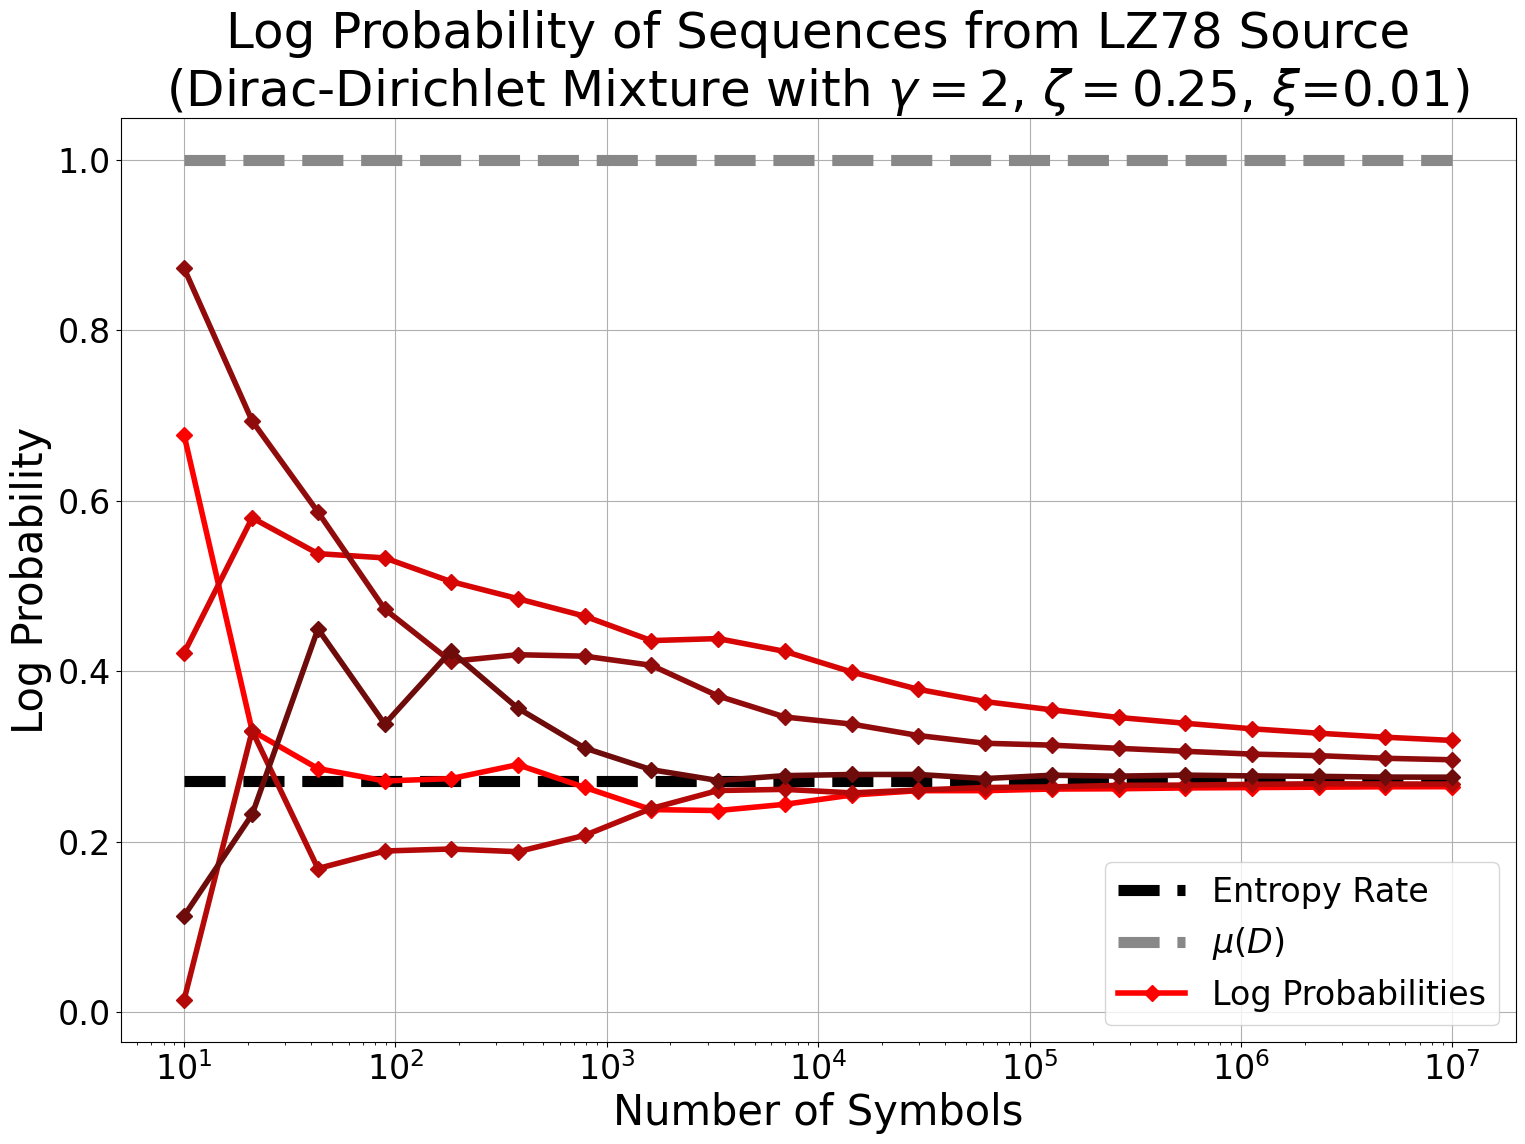

In [11]:
colors = list(Color("#ff0000").range_to(Color("#6e0b0b"),N))

plt.figure(figsize=(18,12))
plt.plot(
    x, np.ones(len(x)) * entropy_rate,
    'k--', linewidth=8, label="Entropy Rate"
)
plt.plot(
    x, np.ones(len(x)) * mu, '--', linewidth=8,
    color="#888888", label="$\mu(D)$"
)

plt.plot(
    x, loss_trials[0], "-D", linewidth=4, markersize=8,
    color="red", label="Log Probabilities"
)
for i in range(1, N):
    plt.plot(
        x, loss_trials[i], "-D", linewidth=4, markersize=8,
        color=colors[i].get_hex()
    )
    
plt.legend(fontsize=24)
plt.xscale("log")
plt.title(f"Log Probability of Sequences from LZ78 Source\n(Dirac-Dirichlet Mixture with $\gamma=${GAMMA}, $\zeta=${DELTA}, $\\xi$={EPSILON})", fontdict={"size": 36})
plt.xlabel("Number of Symbols", fontdict={"size": 30})
plt.ylabel("Log Probability", fontdict={"size": 30})
plt.tick_params(labelsize=24)
plt.grid(True)

In [107]:
stdout.flush()
seq, log_probs, _ = source_experiment(x, GAMMA, DiracDirichletLZ78Source(GAMMA, DELTA, EPSILON, seed=i), seed=42)
mu_0 = compute_mu_ks(seq, x, k=0)
mu_5 = compute_mu_ks(seq, x, k=5)
mu_10 = compute_mu_ks(seq, x, k=10)
# mu_31 = compute_mu_ks(seq, x, k=31)

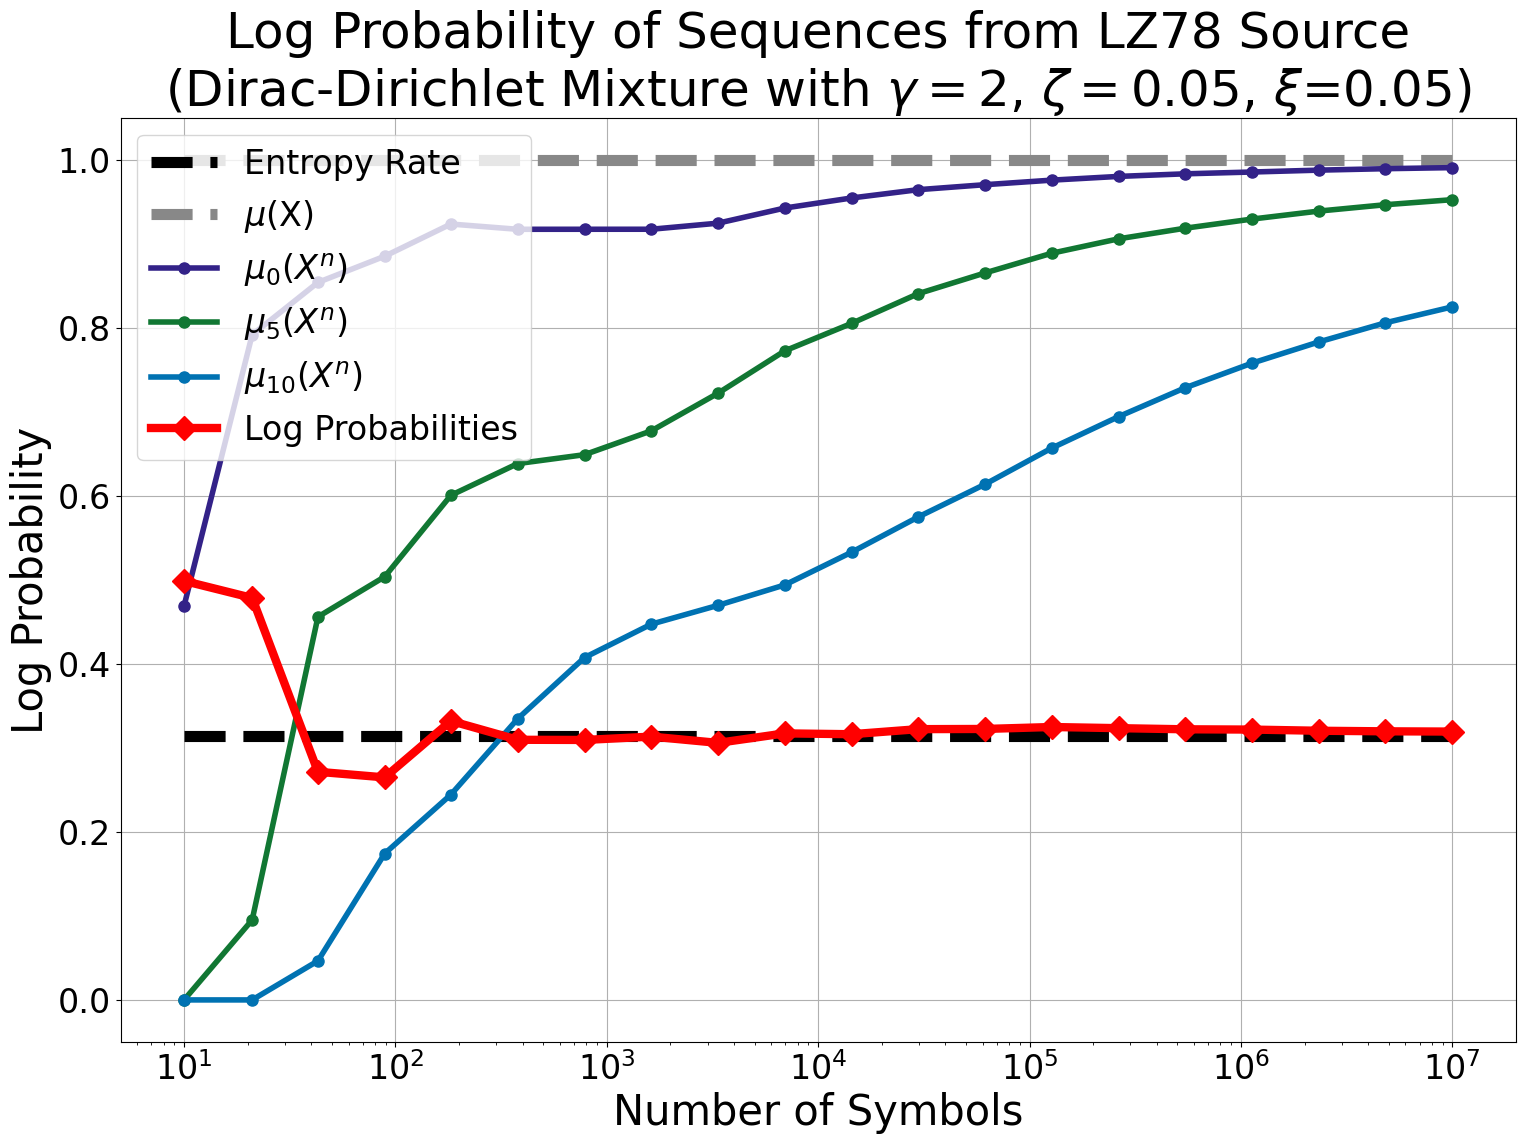

In [108]:
plt.figure(figsize=(18,12))
plt.plot(
    x, np.ones(len(x)) * entropy_rate,
    'k--', linewidth=8, label="Entropy Rate"
)
plt.plot(
    x, np.ones(len(x)) * mu, '--', linewidth=8,
    color="#888888", label="$\mu$(X)"
)

plt.plot(
    x, mu_0, "-o", linewidth=4, markersize=8,
    color="#332288", label="$\mu_0(X^n)$"
) 
plt.plot(
    x, mu_5, "-o", linewidth=4, markersize=8,
    color="#117733", label="$\mu_5(X^n)$"
) 
plt.plot(
    x, mu_10, "-o", linewidth=4, markersize=8,
    color="#0072B2", label="$\mu_{10}(X^n)$"
)
# plt.plot(
#     x, mu_31, "-o", linewidth=2, markersize=3,
#     color="blue", label="$\mu_{31}(D^n)$"
# ) 
plt.plot(
    x, log_probs, "-D", linewidth=6, markersize=12,
    color="red", label="Log Probabilities"
)   
    
plt.legend(fontsize=24)
plt.xscale("log")
plt.title(f"Log Probability of Sequences from LZ78 Source\n(Dirac-Dirichlet Mixture with $\gamma=${GAMMA}, $\zeta=${DELTA}, $\\xi$={EPSILON})", fontdict={"size": 36})
plt.xlabel("Number of Symbols", fontdict={"size": 30})
plt.ylabel("Log Probability", fontdict={"size": 30})
plt.tick_params(labelsize=24)
plt.grid(True)